In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import cloudpickle as pkl
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from IPython.display import display, HTML, Image

from pathlib import Path
from joblib import delayed, Parallel

In [2]:
target = 'gold'
model_date = '20241121'
version = 2
algo = 'xgb'

model_name = f'{target}_{algo}_{model_date}_v{version}'
with open(f'{target}/{model_name}/calibrated_model.pkl', 'rb') as model_file:
    model = pkl.load(model_file)

In [3]:
train_data = pd.read_csv(f'{target}/train_data_{target}.csv', low_memory=False)
test_data = pd.read_csv(f'{target}/test_data_{target}.csv', low_memory=False)

x_train = train_data.drop('target', axis=1)
y_train = train_data['target']
x_test = test_data.drop('target', axis=1)
y_test = test_data['target']

x_train.shape

(1875246, 10)

## Evaluation

1. Train & Test Gini
2. Decile
3. Feature Importances
4. SHAP Summary Plot

In [4]:
x_test.shape

(468812, 10)

### Gini

In [5]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_auc_scores = []
for train_index, test_index in sss.split(x_train, y_train):
    x_val, y_val = x_train.iloc[train_index], y_train.iloc[train_index]
    y_pred_proba = model.predict_proba(x_val)
    train_auc_scores.append(roc_auc_score(y_val, y_pred_proba[:, 1]))
    
train_auc = np.mean(train_auc_scores)
print(f"""
Train Gini:
    Fold 1: {2 * train_auc_scores[0] - 1:.2f}
    Fold 2: {2 * train_auc_scores[1] - 1:.2f}
    Fold 3: {2 * train_auc_scores[2] - 1:.2f}
    Fold 4: {2 * train_auc_scores[3] - 1:.2f}
    Fold 5: {2 * train_auc_scores[4] - 1:.2f}
    
Average Gini = {2 * train_auc - 1:.2f}
""")


Train Gini:
    Fold 1: 0.75
    Fold 2: 0.75
    Fold 3: 0.75
    Fold 4: 0.75
    Fold 5: 0.74
    
Average Gini = 0.75



In [6]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
test_auc_scores = []
for train_index, test_index in sss.split(x_test, y_test):
    x_val, y_val = x_test.iloc[train_index], y_test.iloc[train_index]
    y_pred_proba = model.predict_proba(x_val)
    test_auc_scores.append(roc_auc_score(y_val, y_pred_proba[:, 1]))

test_auc = np.mean(test_auc_scores)
print(f"""
Test Gini:
    Fold 1: {2 * test_auc_scores[0] - 1:.2f}
    Fold 2: {2 * test_auc_scores[1] - 1:.2f}
    Fold 3: {2 * test_auc_scores[2] - 1:.2f}
    Fold 4: {2 * test_auc_scores[3] - 1:.2f}
    Fold 5: {2 * test_auc_scores[4] - 1:.2f}

Average Gini = {2 * test_auc - 1:.2f}
""")


Test Gini:
    Fold 1: 0.73
    Fold 2: 0.72
    Fold 3: 0.73
    Fold 4: 0.72
    Fold 5: 0.71

Average Gini = 0.72



### Decile Analysis

In [7]:
y_pred_proba = model.predict_proba(x_test)[:, 1]
deciles = pd.qcut(pd.Series(y_pred_proba).rank(method='first'), q=10, labels=False) + 1
deciles_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'Actual': y_test,
    'Decile': deciles,
    'Bin Size': 1
}).sort_values(['Decile', 'Probability'],ascending=False)

agg_deciles_df = deciles_df.groupby('Decile').agg({
    'Probability': 'mean',
    'Actual':'sum',
    'Bin Size': 'sum'
}).reset_index().sort_values(['Decile'], ascending=False)

agg_deciles_df['response_rate'] = agg_deciles_df['Actual'] / y_test.shape[0]
agg_deciles_df['decile_recall'] = agg_deciles_df['Actual'] / y_test.sum()
agg_deciles_df['capture_rate'] = agg_deciles_df['Actual'].cumsum() * 100 / y_test.sum()
agg_deciles_df['Bin Size'] = agg_deciles_df.pop('Bin Size')
display(HTML(f"<h3>Test Data Deciling</h3>{agg_deciles_df.to_html(index=False)}"))

Decile,Probability,Actual,response_rate,decile_recall,capture_rate,Bin Size
10,0.010989,512,0.001092,0.645649,64.564943,46882
9,0.002304,110,0.000235,0.138714,78.436318,46881
8,0.001184,53,0.000113,0.066835,85.119798,46881
7,0.000572,21,0.000045,0.026482,87.767970,46881
6,0.000516,29,0.000062,0.036570,91.424968,46881
5,0.000389,24,0.000051,0.030265,94.451450,46881
4,0.000331,17,0.000036,0.021438,96.595208,46881
3,0.000231,14,0.000030,0.017654,98.360656,46881
2,0.000160,5,0.000011,0.006305,98.991173,46881
1,0.000131,8,0.000017,0.010088,100.000000,46882


In [19]:
agg_deciles_df.to_csv("Testing Decile Analysis Gold.csv",index=False)

In [8]:
y_pred_proba_train = model.predict_proba(x_train)[:, 1]
deciles_train = pd.qcut(pd.Series(y_pred_proba_train).rank(method='first'), q=10, labels=False) + 1
deciles_df_train = pd.DataFrame({
    'Probability': y_pred_proba_train,
    'Actual': y_train,
    'Decile': deciles_train,
    'Bin Size': 1
}).sort_values(['Decile', 'Probability'],ascending=False)

agg_deciles_df_train = deciles_df_train.groupby('Decile').agg({
    'Probability': 'mean',
    'Actual':'sum',
    'Bin Size': 'sum'
}).reset_index().sort_values(['Decile'], ascending=False)

agg_deciles_df_train['response_rate'] = agg_deciles_df_train['Actual'] / y_train.shape[0]
agg_deciles_df_train['decile_recall'] = agg_deciles_df_train['Actual'] / y_train.sum()
agg_deciles_df_train['capture_rate'] = agg_deciles_df_train['Actual'].cumsum() * 100 / y_train.sum()
agg_deciles_df_train['Bin Size'] = agg_deciles_df_train.pop('Bin Size')
display(HTML(f"<h3>Train Data Deciling</h3>{agg_deciles_df_train.to_html(index=False)}"))

Decile,Probability,Actual,response_rate,decile_recall,capture_rate,Bin Size
10,0.011115,2087,0.001113,0.657737,65.773716,187525
9,0.002304,439,0.000234,0.138355,79.609203,187524
8,0.001183,212,0.000113,0.066814,86.290577,187525
7,0.000572,113,0.000060,0.035613,89.851875,187524
6,0.000515,83,0.000044,0.026158,92.467696,187525
5,0.000389,74,0.000039,0.023322,94.799874,187524
4,0.000330,69,0.000037,0.021746,96.974472,187525
3,0.000231,40,0.000021,0.012606,98.235109,187524
2,0.000159,34,0.000018,0.010715,99.306650,187525
1,0.000131,22,0.000012,0.006934,100.000000,187525


In [21]:
agg_deciles_df_train.to_csv("Training Decile Analysis Gold.csv",index=False)

### Response Rate Plots

In [9]:
plot_df = agg_deciles_df[['Decile', 'Probability', 'response_rate']].copy()
# plot_df.Probability = plot_df.Probability * 100

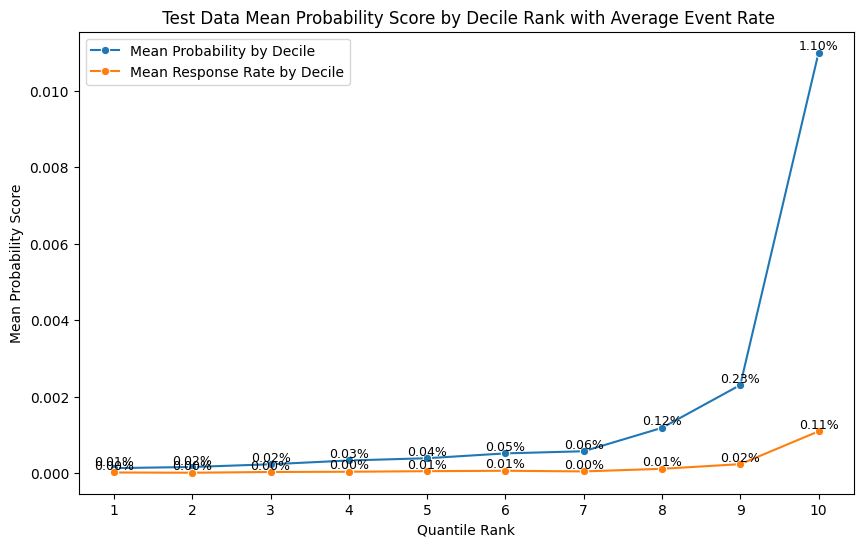

In [10]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='Decile', y='Probability', marker='o', label='Mean Probability by Decile')
sns.lineplot(data=plot_df, x='Decile', y='response_rate', marker='o', label='Mean Response Rate by Decile')

# # Add shaded regions
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability']> plot_df['response_rate']),
#     color='blue', alpha=0.3, interpolate=True, label='Above Response Rate'
# )
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability'] <= plot_df['response_rate']),
#     color='red', alpha=0.3, interpolate=True, label='Below Response Rate'
# )

# Add capture rate annotations
for i, row in agg_deciles_df.iterrows():
    plt.text(row['Decile'], row['response_rate'], f"{row['response_rate'] * 100:.2f}%", 
             ha='center', va='bottom', fontsize=9, color='black')
for i, row in agg_deciles_df.iterrows():
    plt.text(row['Decile'], row['Probability'], f"{row['Probability'] * 100:.2f}%", 
             ha='center', va='bottom', fontsize=9, color='black')

# Adding labels and title
plt.xlabel("Quantile Rank")
plt.ylabel("Mean Probability Score")
plt.title(" Test Data Mean Probability Score by Decile Rank with Average Event Rate")
plt.legend()
plt.grid(False)
plt.xticks(ticks=agg_deciles_df['Decile'], labels=agg_deciles_df['Decile'])
Path(f'{target}/{model_name}/Response_Rate_Plots').mkdir(exist_ok=True)
plt.savefig(f'{target}/{model_name}/Response_Rate_Plots/Test Data Probability Score Plot.png')
plt.show()

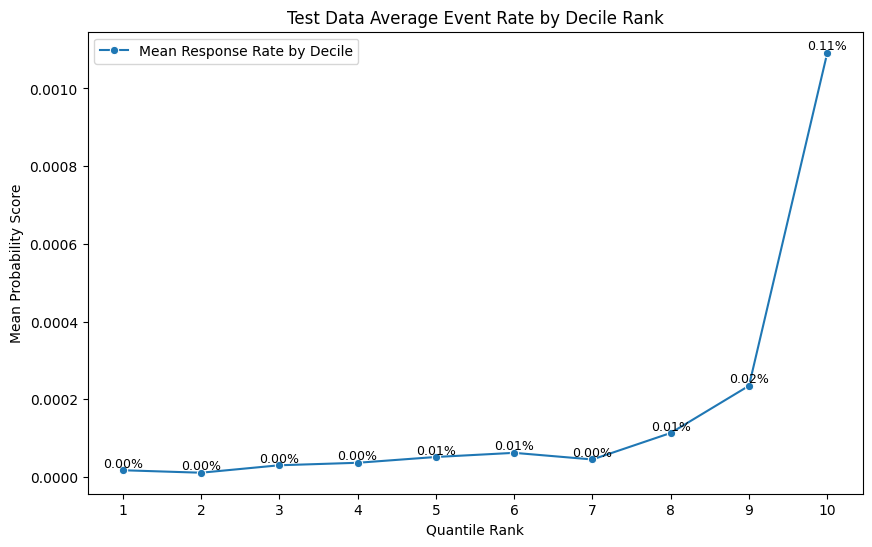

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='Decile', y='response_rate', marker='o', label='Mean Response Rate by Decile')

# # Add shaded regions
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability']> plot_df['response_rate']),
#     color='blue', alpha=0.3, interpolate=True, label='Above Response Rate'
# )
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability'] <= plot_df['response_rate']),
#     color='red', alpha=0.3, interpolate=True, label='Below Response Rate'
# )

# Add capture rate annotations
for i, row in agg_deciles_df.iterrows():
    plt.text(row['Decile'], row['response_rate'], f"{row['response_rate'] * 100:.2f}%", 
             ha='center', va='bottom', fontsize=9, color='black')

# Adding labels and title
plt.xlabel("Quantile Rank")
plt.ylabel("Mean Probability Score")
plt.title("Test Data Average Event Rate by Decile Rank")
plt.legend()
plt.grid(False)
plt.xticks(ticks=agg_deciles_df['Decile'], labels=agg_deciles_df['Decile'])
plt.savefig(f'{target}/{model_name}/Response_Rate_Plots/Test Data Response Rate Plot.png')
plt.show()

In [12]:
plot_df = agg_deciles_df_train[['Decile', 'Probability', 'response_rate']].copy()
# plot_df.Probability = plot_df.Probability * 100

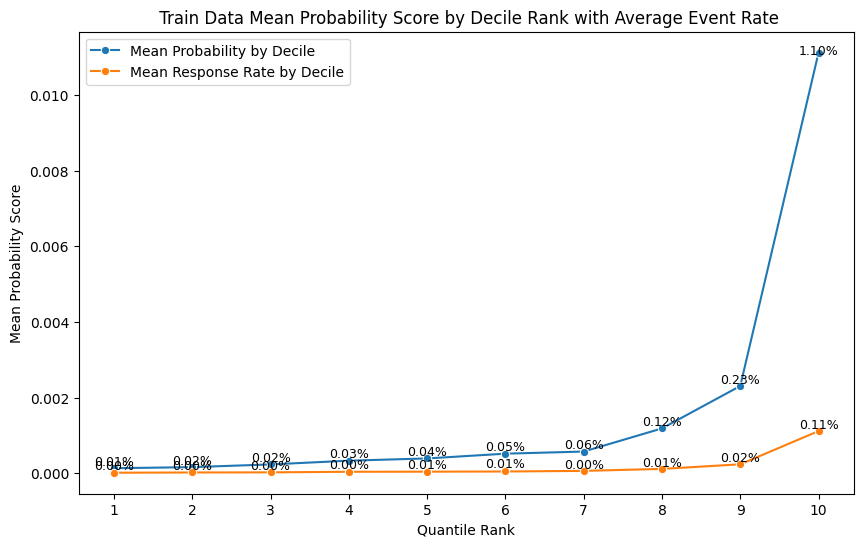

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='Decile', y='Probability', marker='o', label='Mean Probability by Decile')
sns.lineplot(data=plot_df, x='Decile', y='response_rate', marker='o', label='Mean Response Rate by Decile')

# # Add shaded regions
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability']> plot_df['response_rate']),
#     color='blue', alpha=0.3, interpolate=True, label='Above Response Rate'
# )
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability'] <= plot_df['response_rate']),
#     color='red', alpha=0.3, interpolate=True, label='Below Response Rate'
# )

# Add capture rate annotations
for i, row in agg_deciles_df.iterrows():
    plt.text(row['Decile'], row['response_rate'], f"{row['response_rate'] * 100:.2f}%", 
             ha='center', va='bottom', fontsize=9, color='black')
for i, row in agg_deciles_df.iterrows():
    plt.text(row['Decile'], row['Probability'], f"{row['Probability'] * 100:.2f}%", 
             ha='center', va='bottom', fontsize=9, color='black')

# Adding labels and title
plt.xlabel("Quantile Rank")
plt.ylabel("Mean Probability Score")
plt.title(" Train Data Mean Probability Score by Decile Rank with Average Event Rate")
plt.legend()
plt.grid(False)
plt.xticks(ticks=agg_deciles_df['Decile'], labels=agg_deciles_df['Decile'])
Path(f'{target}/{model_name}/Response_Rate_Plots').mkdir(exist_ok=True)
plt.savefig(f'{target}/{model_name}/Response_Rate_Plots/Train Data Probability Score Plot.png')
plt.show()

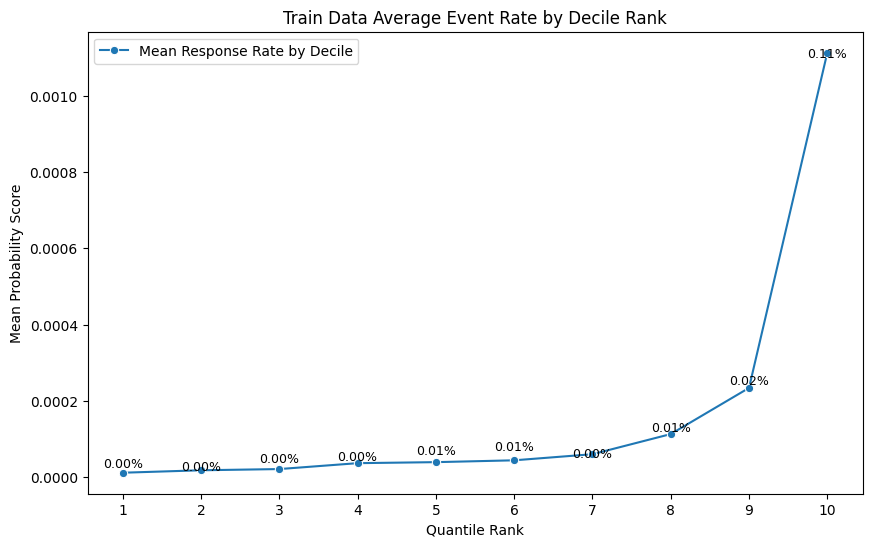

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='Decile', y='response_rate', marker='o', label='Mean Response Rate by Decile')

# # Add shaded regions
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability']> plot_df['response_rate']),
#     color='blue', alpha=0.3, interpolate=True, label='Above Response Rate'
# )
# plt.fill_between(
#     plot_df['Decile'],
#     plot_df['Probability'],
#     plot_df['response_rate'],
#     where=(plot_df['Probability'] <= plot_df['response_rate']),
#     color='red', alpha=0.3, interpolate=True, label='Below Response Rate'
# )

# Add capture rate annotations
for i, row in agg_deciles_df.iterrows():
    plt.text(row['Decile'], row['response_rate'], f"{row['response_rate'] * 100:.2f}%", 
             ha='center', va='bottom', fontsize=9, color='black')

# Adding labels and title
plt.xlabel("Quantile Rank")
plt.ylabel("Mean Probability Score")
plt.title("Train Data Average Event Rate by Decile Rank")
plt.legend()
plt.grid(False)
plt.xticks(ticks=agg_deciles_df['Decile'], labels=agg_deciles_df['Decile'])
plt.savefig(f'{target}/{model_name}/Response_Rate_Plots/Train Data Response Rate Plot.png')
plt.show()

### Feature Importance

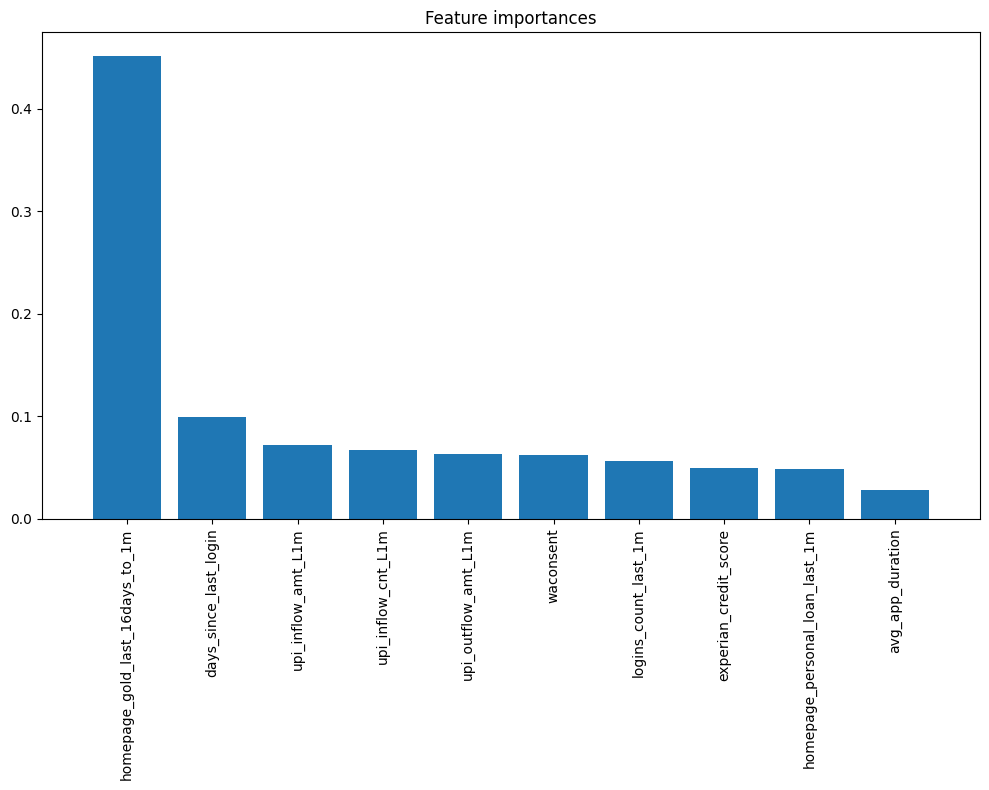

In [15]:
feature_importances = model.estimator.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10,8))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.savefig(f'{target}/{model_name}/model_feature_importances.png')
plt.show()

### SHAP Summary Plots

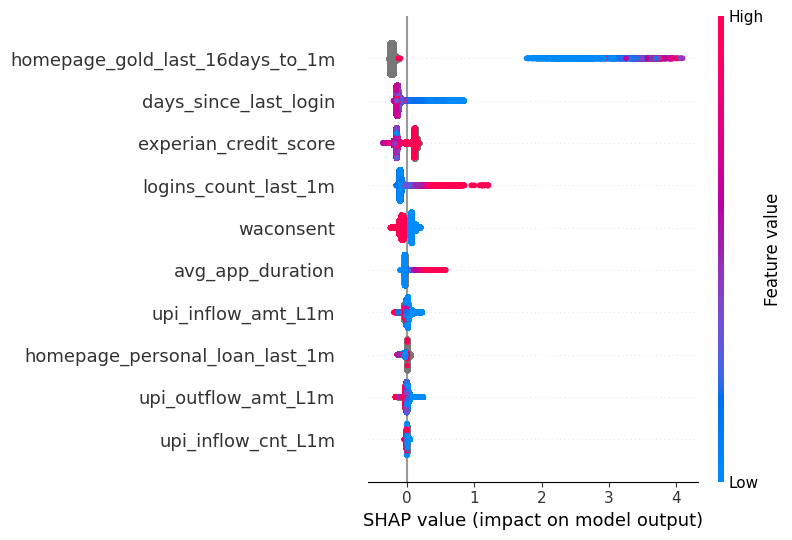

In [16]:
explainer = shap.TreeExplainer(model.estimator)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [17]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

### Partial Dependence Plots

In [ ]:
top_features = x_test.columns.tolist()
top_features = [top_features[i] for i in indices[:5]]
top_features

In [ ]:
%%time
def compute_pdp(feature, model, x_test, target, model_name):
    Path(f'{target}/{model_name}/PDP_Plots').mkdir(exist_ok=True)
    plot_file = f'{target}/{model_name}/PDP_Plots/PDP_{feature}.png'
    if not Path(plot_file).exists():
        fig, ax = plt.subplots()
        shap.partial_dependence_plot(
            feature, 
            lambda x: model.estimator.predict_proba(x)[:, 1],
            x_test,
            ice=True,
            model_expected_value=True,
            feature_expected_value=True,
            ax=ax,
            show=False
        )

        plt.savefig(plot_file)
        plt.close()
    
    return plot_file

plot_files =  Parallel(n_jobs=1)(delayed(compute_pdp)(feature, model, x_test, target, model_name) for feature in top_features)

In [ ]:
for plot_file in plot_files:
    display(Image(filename=plot_file))


### Overall Stats

In [ ]:
# print(f"""STATS
# Event Rate = {(y_train.sum() + y_test.sum()) * 100 / (len(y_train) + len(y_test)):.3f}%

# Training:
#     Gini                = {2 * train_auc - 1:.2f}
#     % in top 3 decile   = {agg_deciles_df_train.iloc[2]['capture_rate']:.2f}%
# Testing 
#     Gini                = {2 * test_auc - 1:.2f}
#     % in top 3 decile   = {agg_deciles_df.iloc[2]['capture_rate']:.2f}%
# """)

In [ ]:
pd.DataFrame(y_pred_proba_train).nunique(), x_train.shape[0]

In [ ]:
pd.DataFrame(y_pred_proba).nunique(), x_test.shape[0]